In [18]:
import sqlite3
import pandas as pd
import os 
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('/Users/louise/Documents/PJTS/SQL/Formation/SQL_Explorer/BabyNames Trends')
conn= sqlite3.connect("datacamp_python.db")

In [2]:
df_names = pd.read_csv("NationalNames.csv")
df_columns = df_names.columns
df_names.head(5)

,Id,Name,Year,Gender,Count
0,1,Mary,1880,F,7065
1,2,Anna,1880,F,2604
2,3,Emma,1880,F,2003
3,4,Elizabeth,1880,F,1939
4,5,Minnie,1880,F,1746


In [3]:
df_names.to_sql(
            'baby_names',            
             conn,                
             if_exists='replace'
            )

1825433

In [4]:
cursor = conn.cursor()

This dataset, provided by the U.S. Social Security Administration, contains baby names given to at least **5,000 American newborns each year** over a period of **101 years**. The main goal is to analyze **how Americans' naming preferences have evolved over time** by studying popularity trends. Specifically, this dataset allows us to explore:  


# 📊 Database Overview

This script analyzes the `baby_names` table and provides a statistical summary of each column, including:

- **Column Name**: The name of the column.
- **Missing Values**: The number of missing (NULL) values in the column.
- **Distinct Values**: The number of unique values in the column.
- **Min Value**: The smallest value in the column (numerically or alphabetically).
- **Max Value**: The largest value in the column (numerically or alphabetically).

This overview helps understand data quality, detect missing values, and analyze the distribution of values in the dataset.


In [5]:
data_overview = []

for col in df_columns:
    query = f"""
        SELECT 
            COUNT(*) - COUNT({col}) AS missing_values,
            COUNT(DISTINCT {col}) AS distinct_values,
            MIN({col}) AS min_value,
            MAX({col}) AS max_value
        FROM baby_names;
    """
    data_sql_col = pd.read_sql(query, conn)
    
    data_overview.append([
        col, 
        data_sql_col['missing_values'][0], 
        data_sql_col['distinct_values'][0], 
        data_sql_col['min_value'][0], 
        data_sql_col['max_value'][0]
    ])

df_overview = pd.DataFrame(data_overview, columns=["Column", "Missing Values", "Distinct Values", "Min Value", "Max Value"])
display(df_overview)


,Column,Missing Values,Distinct Values,Min Value,Max Value
0,Id,0,1825433,1,1825433
1,Name,0,93889,Aaban,Zzyzx
2,Year,0,135,1880,2014
3,Gender,0,2,F,M
4,Count,0,13547,5,99680


# Evolution of Timeless Baby Names in the U.S.

In [6]:
cursor = conn.cursor()
data_sql_names = pd.read_sql("""
    WITH trends AS (
        SELECT
                Name,
                Gender,
                COUNT(DISTINCT Year) AS total_count_year,
                SUM(CASE WHEN Year BETWEEN 1880 AND 1900 THEN count ELSE 0 END) / 20.0 AS first_decade_avg,
                SUM(CASE WHEN Year BETWEEN 1994 AND 2014 THEN count ELSE 0 END) / 20.0 AS last_decade_avg
        FROM baby_names
        GROUP BY Name, Gender
    )
    SELECT 
        b.Name, 
        b.Gender,
        SUM(b.Count) AS total_count,
        t.last_decade_avg / NULLIF(t.first_decade_avg, 0) AS trend_ratio,
        CASE 
            WHEN t.last_decade_avg / NULLIF(t.first_decade_avg, 0) > 1.1 THEN '📈 Increasing'
            WHEN t.last_decade_avg / NULLIF(t.first_decade_avg, 0) < 0.9 THEN '📉 Decreasing'
            ELSE '➖ Stable'
        END AS trend_status
    FROM baby_names b
    JOIN trends t ON b.Name = t.Name AND b.Gender = t.Gender
    GROUP BY b.Name, t.first_decade_avg, t.last_decade_avg, b.Gender
    HAVING total_count_year = (SELECT COUNT(DISTINCT Year) FROM baby_names)
    ORDER BY total_count DESC;
""", conn)


display(data_sql_names)

,Name,Gender,total_count,trend_ratio,trend_status
0,James,M,5105919,3.200034,📈 Increasing
1,John,M,5084943,1.923557,📈 Increasing
2,Robert,M,4796695,4.520852,📈 Increasing
3,Michael,M,4309198,70.596267,📈 Increasing
4,Mary,F,4115282,0.421351,📉 Decreasing
...,...,...,...,...,...
929,Nevada,F,2825,2.992701,📈 Increasing
930,Phebe,F,2632,1.534653,📈 Increasing
931,West,M,2590,2.948413,📈 Increasing
932,Sena,F,2568,1.471963,📈 Increasing


The dataset provides insights into the long-term popularity trends of baby names in the U.S., focusing on names that have been consistently given over all recorded years.  

- **There are 934 names** that have appeared in every year recorded in the dataset, representing around **1% of all names**. This suggests these names are **persistent and timeless** across generations.  
- **The most popular names** are **James (5.1M), John (5.08M), Robert (4.79M), and Michael (4.3M)**—all of which are **male names**. These names are classified as **📈 Increasing**, meaning their popularity has risen over time.  
- **"Michael" stands out** with a remarkably high **trend ratio of 70.6**, indicating a **massive surge in popularity** in recent decades.  
- **"Mary" is the most popular female name** historically (**4.1M occurrences**) but is categorized as **📉 Decreasing**, showing a decline in recent years.  
- **Some less common names** like **"Nevada," "Phebe," and "West"** show a **growing trend**, reflecting modern naming preferences.  

These insights highlight the **stability of classic names**, the **decline of certain traditional female names**, and the **rise of unique names in recent years**. 🚀  



# Baby Name Popularity Analysis  

## 🔹 1. Distribution of Name Popularity  

To understand the overall distribution of name popularity, we calculated key **statistical metrics**:

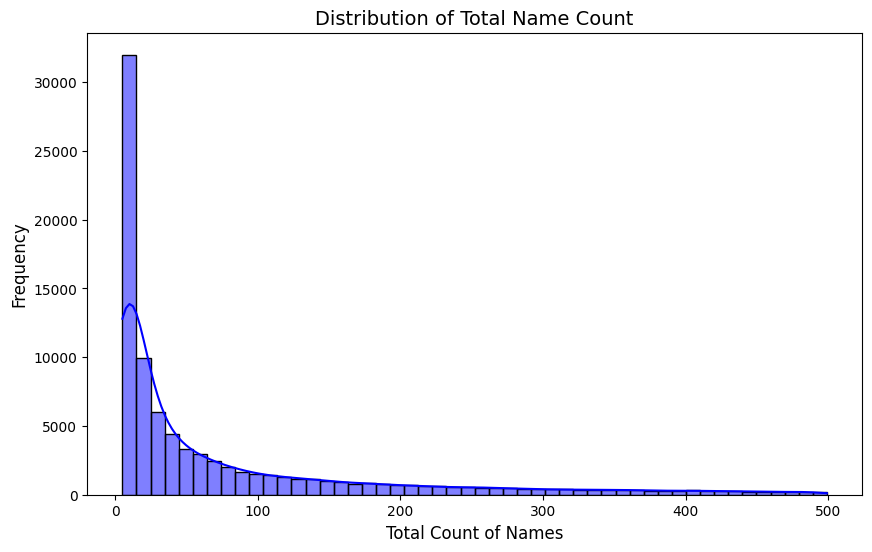

In [22]:
data_sql_distribution = pd.read_sql("""
    SELECT Name, Gender, SUM(Count) AS total_count
    FROM baby_names
    GROUP BY Name, Gender HAVING total_count < 500;
""", conn)


plt.figure(figsize=(10, 6))
sns.histplot(data_sql_distribution["total_count"], bins=50, kde=True, color="blue")

plt.xlabel("Total Count of Names", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Total Name Count", fontsize=14)
plt.show()

- The average total occurrences of a name is **3,238**.  
- Most names have **fewer than 1,621 occurrences**, but **some names appear millions of times**, creating a highly **skewed distribution**.  
- The upper quartile (Q2) is **2.55 million**, indicating that only a small fraction of names have exceptionally high counts.  

## 🔹 2. Name Categorization Based on Popularity  

Each name was classified into four **popularity tiers** based on its total occurrences:

In [23]:
data_sql_cate = pd.read_sql("""
                         WITH table_count AS (
                            SELECT Name, Gender, SUM(Count) AS total_count
                            FROM baby_names
                            GROUP BY Name, Gender
                        )
                        SELECT
                            Name, Gender, 
                            SUM(Count) AS total_count,
                            CASE WHEN SUM(Count) > (SELECT (AVG(total_count) + MAX(total_count)) /2 FROM table_count) THEN 'Classic'
                                WHEN SUM(Count) > (SELECT AVG(total_count) FROM table_count) THEN 'Semi-classic'
                                WHEN SUM(Count) > (SELECT (AVG(total_count) + MIN(total_count)) /2 FROM table_count) THEN 'Semi-trendy'
                                ELSE 'Trendy' END AS Popularity_Type
                            FROM baby_names
                        GROUP BY Name, Gender 
                        ORDER BY Popularity_Type;
                        """,
                        conn)
print(data_sql_cate)

             Name Gender  total_count Popularity_Type
0           David      M      3577704         Classic
1           James      M      5105919         Classic
2            John      M      5084943         Classic
3          Joseph      M      2570095         Classic
4            Mary      F      4115282         Classic
...           ...    ...          ...             ...
104105  Zytavious      M           43          Trendy
104106     Zyvion      M            5          Trendy
104107    Zyyanna      F            6          Trendy
104108      Zyyon      M            6          Trendy
104109      Zzyzx      M            5          Trendy

[104110 rows x 4 columns]


- **Classic names** like **James, John, Mary, and David** have been used millions of times, making them **timeless choices**.
- **Trendy names** like **Zyyanna and Zzyzx** have appeared only a handful of times, reflecting **modern and unique naming preferences**.
- The dataset contains **more classic male names** than female ones, prompting further analysis.

## 🔹 3. Female Name Rankings 

To ensure better **gender representation**, a separate ranking was created for **female names**:


In [19]:
data_sql_cate = pd.read_sql("""
                         WITH table_count AS (
                            SELECT Name, Gender, SUM(Count) AS total_count
                            FROM baby_names
                            GROUP BY Name, Gender
                        ),
                        ranked_table AS (
                            SELECT 
                                Name, Gender, 
                                SUM(Count) AS total_count,
                                CASE 
                                    WHEN SUM(Count) > (SELECT (AVG(total_count) + MAX(total_count)) / 2 FROM table_count) THEN 'Classic'
                                    WHEN SUM(Count) > (SELECT AVG(total_count) FROM table_count) THEN 'Semi-classic'
                                    WHEN SUM(Count) > (SELECT (AVG(total_count) + MIN(total_count)) / 2 FROM table_count) THEN 'Semi-trendy'
                                    ELSE 'Trendy' 
                                END AS Popularity_Type,
                                RANK() OVER (ORDER BY SUM(Count) DESC) AS rank_name
                            FROM baby_names
                            GROUP BY Name, Gender
                        )
                        SELECT * FROM ranked_table
                        WHERE Gender = 'F'  -- Apply filter only after ranking
                        ORDER BY total_count DESC
                        LIMIT 15
                        ;
                        """,
                        conn)
print(data_sql_cate)

         Name Gender  total_count Popularity_Type  rank_name
0        Mary      F      4115282         Classic          5
1   Elizabeth      F      1601128    Semi-classic         14
2    Patricia      F      1570567    Semi-classic         15
3    Jennifer      F      1462742    Semi-classic         17
4       Linda      F      1450843    Semi-classic         19
5     Barbara      F      1432944    Semi-classic         20
6    Margaret      F      1240006    Semi-classic         29
7       Susan      F      1120469    Semi-classic         33
8     Dorothy      F      1105680    Semi-classic         34
9       Sarah      F      1060643    Semi-classic         36
10    Jessica      F      1040574    Semi-classic         38
11      Helen      F      1015902    Semi-classic         39
12      Nancy      F      1000955    Semi-classic         41
13      Betty      F       998851    Semi-classic         42
14      Karen      F       983806    Semi-classic         43


- **Mary** remains the most commonly used **female name**, ranking **5th overall**.
- Other high-ranking female names include **Elizabeth, Patricia, Jennifer, and Linda**.
- **No female names rank within the top 3 names overall**, reinforcing the **strong presence of male names** in classic categories.
